In [28]:
import glob
import multiprocessing
import random
import time
import enum

import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchio as tio
import torchvision
from tqdm import tqdm

from unet import UNet

from scripts.utils.memory import get_total_memory
from scripts.utils.visualization import visualize_subject
from scripts.utils.loading import get_subjects_names
from scripts.load_data import load_data
seed = 42
random.seed(seed)
torch.manual_seed(seed)
%config InlineBackend.figure_format = 'retina'
num_workers = multiprocessing.cpu_count()
plt.rcParams['figure.figsize'] = 12, 6

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

%load_ext autoreload
%autoreload 2

print('Last run on', time.ctime())
print('TorchIO version:', tio.__version__)
print('Device:', device)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Last run on Thu Jul  6 14:10:24 2023
TorchIO version: 0.18.92
Device: cuda


# Data Loading and Visualization

In [3]:
metadata_path = "Data/M&Ms/OpenDataset/211230_M&Ms_Dataset_information_diagnosis_opendataset.csv"
metadata = pd.read_csv(metadata_path, index_col=1).drop(columns="Unnamed: 0")
metadata.head(5)

,VendorName,Vendor,Centre,ED,ES,Age,Pathology,Sex,Height,Weight
External code,,,,,,,,,,
A0S9V9,Siemens,A,1,0,9,67,DCM,M,180.0,88.0
A1D0Q7,Philips,B,2,0,9,79,HCM,F,NaN,88.0
A1D9Z7,Siemens,A,1,22,11,53,HCM,M,175.0,75.0
A1E9Q1,Siemens,A,1,0,9,16,DCM,M,175.0,75.0
A1K2P5,Canon,D,5,33,11,35,DCM,F,170.0,NaN


100%|██████████| 150/150 [00:23<00:00,  6.42it/s]


Training/Labeled/ Dataset size: 3286 subjects
Subject(Keys: ('image', 'seg'); images: 2)
ScalarImage(shape: (1, 1, 128, 128); spacing: (1.22, 1.12, 9.60); orientation: PIR+; dtype: torch.FloatTensor; memory: 64.0 KiB)
LabelMap(shape: (1, 1, 128, 128); spacing: (1.22, 1.12, 9.60); orientation: PIR+; dtype: torch.FloatTensor; memory: 64.0 KiB)


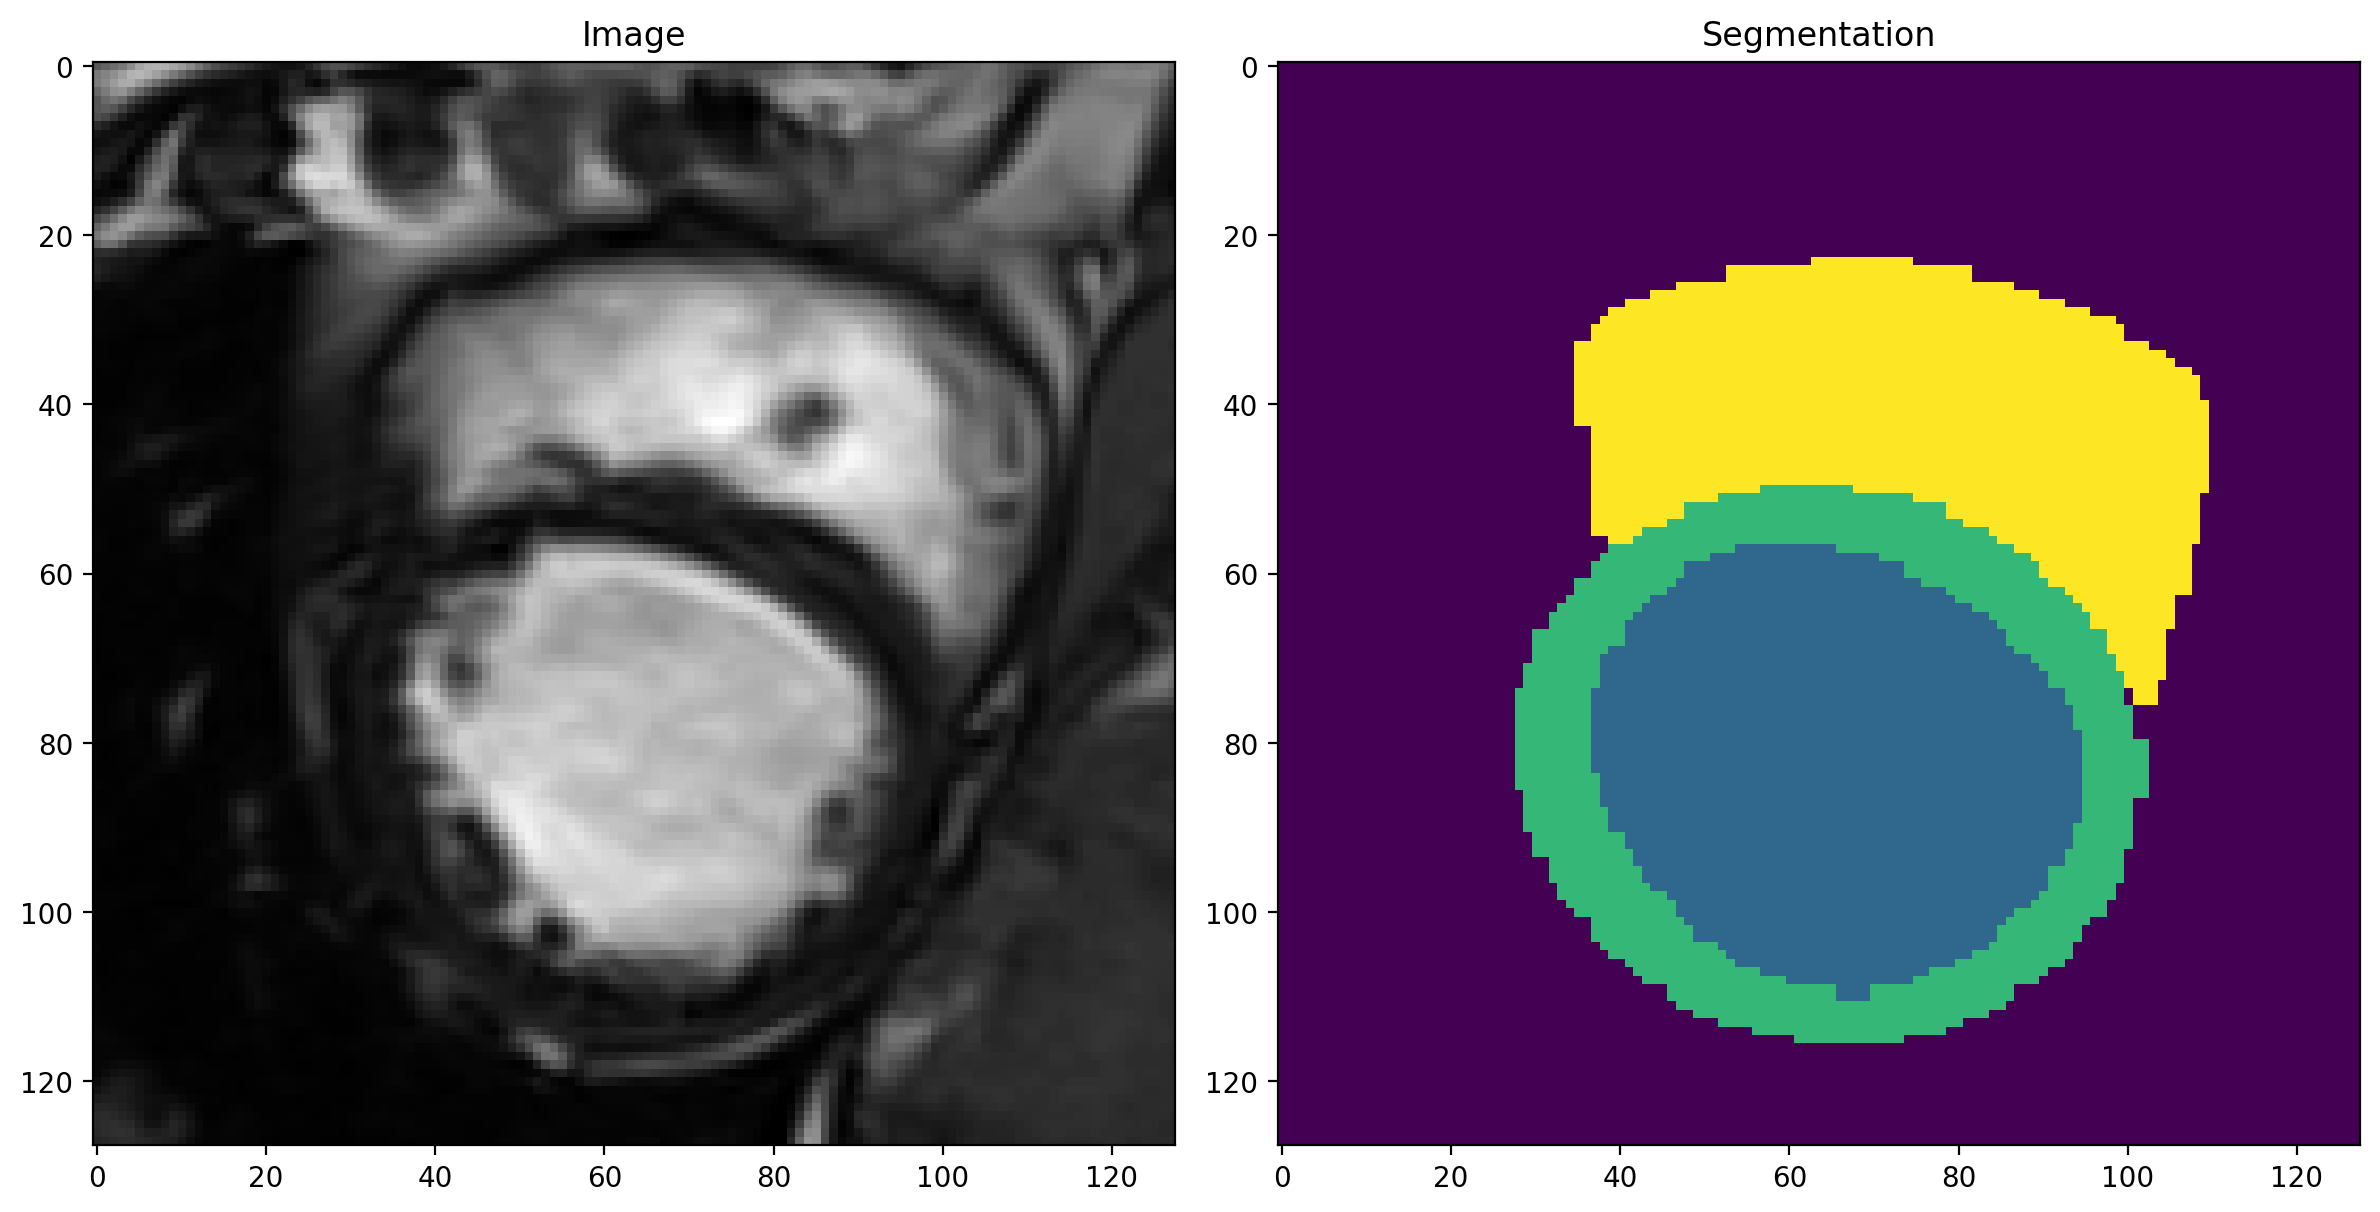

In [26]:
dim=2
train_dataset = load_data("Training/Labeled/", dim=dim)
print("Total memory for train: ", get_total_memory(train_dataset))

one_subject = train_dataset[10]
visualize_subject(one_subject, dim)

# # C8J7L5 was removed from valid
# valid_dataset = load_data("Validation/", dim=dim)
# #E3F5U2, C8O0P2 were removed from test
# test_dataset = load_data("Testing/", dim=dim)

# Unet

In [ ]:
# 
# CHANNELS_DIMENSION = 1
# SPATIAL_DIMENSIONS = 2, 3, 4

# class Action(enum.Enum):
#     TRAIN = 'Training'
#     VALIDATE = 'Validation'

# def prepare_batch(batch, device):
#     inputs = batch['image'][tio.DATA].to(device)
#     targets = batch['seg'][tio.DATA].to(device)
#     return inputs, targets

# def get_dice_score(output, target, epsilon=1e-9):
#     p0 = output
#     g0 = target
#     p1 = 1 - p0
#     g1 = 1 - g0
#     tp = (p0 * g0).sum(dim=SPATIAL_DIMENSIONS)
#     fp = (p0 * g1).sum(dim=SPATIAL_DIMENSIONS)
#     fn = (p1 * g0).sum(dim=SPATIAL_DIMENSIONS)
#     num = 2 * tp
#     denom = 2 * tp + fp + fn + epsilon
#     dice_score = num / denom
#     return dice_score

# def get_dice_loss(output, target):
#     return 1 - get_dice_score(output, target)

# def get_model_and_optimizer(device):
#     model = UNet(
#         in_channels=1,
#         out_classes=4,
#         dimensions=3,
#         num_encoding_blocks=4,
#         out_channels_first_layer=8,
#         normalization='batch',
#         upsampling_type='linear',
#         padding=True,
#         activation='PReLU',
#     ).to(device)
#     optimizer = torch.optim.AdamW(model.parameters())
#     return model, optimizer

# def run_epoch(epoch_idx, action, loader, model, optimizer):
#     is_training = action == Action.TRAIN
#     epoch_losses = []
#     times = []
#     model.train(is_training)
#     for batch_idx, batch in enumerate(tqdm(loader)):
#         inputs, targets = prepare_batch(batch, device)
#         optimizer.zero_grad()
#         with torch.set_grad_enabled(is_training):
#             logits = model(inputs)
#             probabilities = F.softmax(logits, dim=CHANNELS_DIMENSION)
#             batch_losses = get_dice_loss(probabilities, targets)
#             batch_loss = batch_losses.mean()
#             if is_training:
#                 batch_loss.backward()
#                 optimizer.step()
#             times.append(time.time())
#             epoch_losses.append(batch_loss.item())
#     epoch_losses = np.array(epoch_losses)
#     print(f'{action.value} mean loss: {epoch_losses.mean():0.3f}')
#     return times, epoch_losses

# def train(num_epochs, training_loader, validation_loader, model, optimizer, weights_stem):
#     train_losses = []
#     val_losses = []
#     val_losses.append(run_epoch(0, Action.VALIDATE, validation_loader, model, optimizer))
#     for epoch_idx in range(1, num_epochs + 1):
#         print('Starting epoch', epoch_idx)
#         train_losses.append(run_epoch(epoch_idx, Action.TRAIN, training_loader, model, optimizer))
#         val_losses.append(run_epoch(epoch_idx, Action.VALIDATE, validation_loader, model, optimizer))
#         torch.save(model.state_dict(), f'{weights_stem}_epoch_{epoch_idx}.pth')
#     return np.array(train_losses), np.array(val_losses)

In [ ]:
# training_batch_size = 16
# validation_batch_size = 2 * training_batch_size

# training_loader = torch.utils.data.DataLoader(
#     train_dataset,
#     batch_size=training_batch_size,
#     shuffle=True,
#     num_workers=num_workers,
# )

# validation_loader = torch.utils.data.DataLoader(
#     valid_dataset,
#     batch_size=validation_batch_size,
#     num_workers=num_workers,
# )

In [ ]:
# k = 24
# batch_mri = one_batch['mri'][tio.DATA][..., k]
# batch_label = one_batch['brain'][tio.DATA][:, 1:, ..., k]
# slices = torch.cat((batch_mri, batch_label))
# image_path = 'batch_whole_images.png'
# torchvision.utils.save_image(
#     slices,
#     image_path,
#     nrow=training_batch_size//2,
#     normalize=True,
#     scale_each=True,
#     padding=0,
# )
# display.Image(image_path)